In [1]:
import os
from langchain_groq import ChatGroq
from langchain.schema import Document

os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
model = ChatGroq(model="llama3-70b-8192")

from langchain.tools import StructuredTool
from pydantic import BaseModel,Field

class MultiplyInput(BaseModel):
    a:int=Field(...,description="Enter interger value of a")
    b:int=Field(...,description="Enter interger value of b")  # The ... is a shorthand for saying “no default value, this field is required”.



def multiply(a:int,b:int)->int:
    return a*b

from langchain.tools import StructuredTool

multiply_tool = StructuredTool.from_function(func=multiply,
                                             name="mulitplyfunction",
                                             description="it use to multiple two function",
                                             args_schema=MultiplyInput)

RESULT = multiply_tool.invoke({"a":1,"b":10})

print(RESULT)

10


In [2]:
bound_model = model.bind_tools([multiply_tool])

In [3]:
bound_model.invoke("mulitplication of two number is 2,4")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ezdwcqgxe', 'function': {'arguments': '{"a":2,"b":4}', 'name': 'mulitplyfunction'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 932, 'total_tokens': 983, 'completion_time': 0.145714286, 'prompt_time': 0.030171333, 'queue_time': 0.05305975599999999, 'total_time': 0.175885619}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5813411b-ac85-4328-9deb-40ddba496541-0', tool_calls=[{'name': 'mulitplyfunction', 'args': {'a': 2, 'b': 4}, 'id': 'ezdwcqgxe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 932, 'output_tokens': 51, 'total_tokens': 983})

In [126]:
import json

def extract_tool(tool_result)->dict:
    # print(tool_result)

    messages = []
    last_message = tool_result['messages'][-1]

    all_tools = last_message.tool_calls
    
    for tool in all_tools:
        print(tool)
        if tool['name']=="mulitplyfunction":
            result = multiply_tool.invoke(tool)
            messages.append(result)
            # message_list.append(AIMessage(content=json.dumps(result)))

    return {"messages":messages}

# final_result = extract_tool(tool_result)
# final_result

In [ ]:

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages :Annotated[list, add_messages]


In [128]:
# create node object

graph_builder = StateGraph(State)

In [129]:
#first node starting node with anem of chatbot

def chatbot(state:State):
    return {"messages":[bound_model.invoke(state['messages'])]}

In [130]:
graph_builder.add_node("chatbot",chatbot) # define node 


# agent calling

graph_builder.add_node("toolcalling",extract_tool)

In [131]:
# we giving condiional edge does really we need to call tool

from langgraph.graph import MessagesState
from typing import Literal
def should_continue(state:MessagesState)->Literal['toolcalling',END]:
    messages = state['messages']
    
    # get last messages
    last_message = messages[-1]
    if last_message.tool_calls:
        return "toolcalling"
    return END

In [132]:
# add conditional edge

graph_builder.add_conditional_edges('chatbot',should_continue,['toolcalling',END])

In [133]:
graph_builder.add_edge("toolcalling","chatbot")
graph_builder.add_edge(START,"chatbot")


In [134]:
from langgraph.checkpoint.memory import MemorySaver

# For production use cases we recommend installing [langgraph-checkpoint-postgres](https://pypi.org/project/langgraph-checkpoint-postgres/) and using `PostgresSaver` / `AsyncPostgresSaver`.


memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

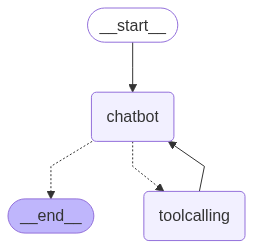

In [135]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [136]:
config = {"configurable": {"thread_id": "1"}}


In [137]:
from langchain_core.messages import HumanMessage
user_input = "what is muliplication of 2,2"

# Use the Runnable
final_state = graph.invoke(
    {"messages": [HumanMessage(content=user_input)]},
    config=config
)
final_state["messages"][-1].content

{'name': 'mulitplyfunction', 'args': {'a': 2, 'b': 2}, 'id': '0axgptx8h', 'type': 'tool_call'}


'The multiplication of 2 and 2 is 4.'